In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [4]:
import torch.nn.functional as F

# from .unet_parts import *

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class generator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(generator, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [6]:
class UnderwaterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.raw_dir = os.path.join(root_dir, 'Raw')
        self.ref_dir = os.path.join(root_dir, 'Reference')
        self.raw_images = os.listdir(self.raw_dir)
        self.ref_images = os.listdir(self.ref_dir)
        self.transform = transform

    def __len__(self):
        return len(self.raw_images)

    def __getitem__(self, idx):
        raw_image = Image.open(os.path.join(self.raw_dir, self.raw_images[idx]))
        ref_image = Image.open(os.path.join(self.ref_dir, self.ref_images[idx]))
        
        if self.transform:
            raw_image = self.transform(raw_image)
            ref_image = self.transform(ref_image)

        return raw_image, ref_image

# Data transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Load the dataset
train_dataset = UnderwaterDataset(root_dir='/kaggle/input/wec-task-2/Train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [8]:
import torch.nn as nn
import torch.optim as optim

In [9]:
# Initialize the generator and discriminator models
generator = UNet(n_channels=3, n_classes=3)
discriminator = discriminator()

In [10]:
generator.apply(lambda m: normal_init(m, mean=0.0, std=0.02))
discriminator.apply(lambda m: normal_init(m, mean=0.0, std=0.02))


discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)
device

device(type='cuda')

In [12]:
# Loss functions
bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss for the GAN
l1_loss = nn.L1Loss()    # L1 Loss for image reconstruction

# Optimizers for generator and discriminator
gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [13]:
# Training loop parameters
num_epochs = 100 #100
lambda_L1 = 100  # Weighting factor for the L1 loss

for epoch in range(num_epochs):
    for i, (raw_images, ref_images) in enumerate(train_loader):
        # Move data to the GPU
        raw_images = raw_images.to(device)
        ref_images = ref_images.to(device)
        
        # Adversarial ground truths
        valid = torch.ones(raw_images.size(0), 1, 30, 30).to(device)  # Real labels
        fake = torch.zeros(raw_images.size(0), 1, 30, 30).to(device)  # Fake labels
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        disc_optimizer.zero_grad()

        # Real image loss
        real_output = discriminator(ref_images, raw_images)
        real_loss = bce_loss(real_output, valid)

        # Fake image loss
        fake_images = generator(raw_images)
        fake_output = discriminator(fake_images.detach(), raw_images)
        fake_loss = bce_loss(fake_output, fake)

        # Total discriminator loss
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        disc_optimizer.step()

        # -----------------
        #  Train Generator
        # -----------------
        gen_optimizer.zero_grad()

        # GAN loss
        fake_output = discriminator(fake_images, raw_images)
        gan_loss = bce_loss(fake_output, valid)

        # L1 loss (reconstruction)
        l1 = l1_loss(fake_images, ref_images)

        # Total generator loss
        gen_loss = gan_loss + lambda_L1 * l1
        gen_loss.backward()
        gen_optimizer.step()

        # Print progress
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(train_loader)}] \
                  Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

Epoch [1/100] Batch [0/44]                   Discriminator Loss: 0.8812, Generator Loss: 50.5669
Epoch [1/100] Batch [10/44]                   Discriminator Loss: 0.7213, Generator Loss: 29.5530
Epoch [1/100] Batch [20/44]                   Discriminator Loss: 0.6535, Generator Loss: 23.5942
Epoch [1/100] Batch [30/44]                   Discriminator Loss: 0.7979, Generator Loss: 21.6369
Epoch [1/100] Batch [40/44]                   Discriminator Loss: 0.5958, Generator Loss: 23.8087
Epoch [2/100] Batch [0/44]                   Discriminator Loss: 0.6898, Generator Loss: 23.4148
Epoch [2/100] Batch [10/44]                   Discriminator Loss: 0.5865, Generator Loss: 19.6876
Epoch [2/100] Batch [20/44]                   Discriminator Loss: 0.6486, Generator Loss: 18.3419
Epoch [2/100] Batch [30/44]                   Discriminator Loss: 0.6363, Generator Loss: 20.2798
Epoch [2/100] Batch [40/44]                   Discriminator Loss: 0.5515, Generator Loss: 19.0199
Epoch [3/100] Batch [0

In [14]:
test_dataset = UnderwaterDataset(root_dir='/kaggle/input/wec-task-2/Test', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [15]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import numpy as np

In [16]:
generator.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [17]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt

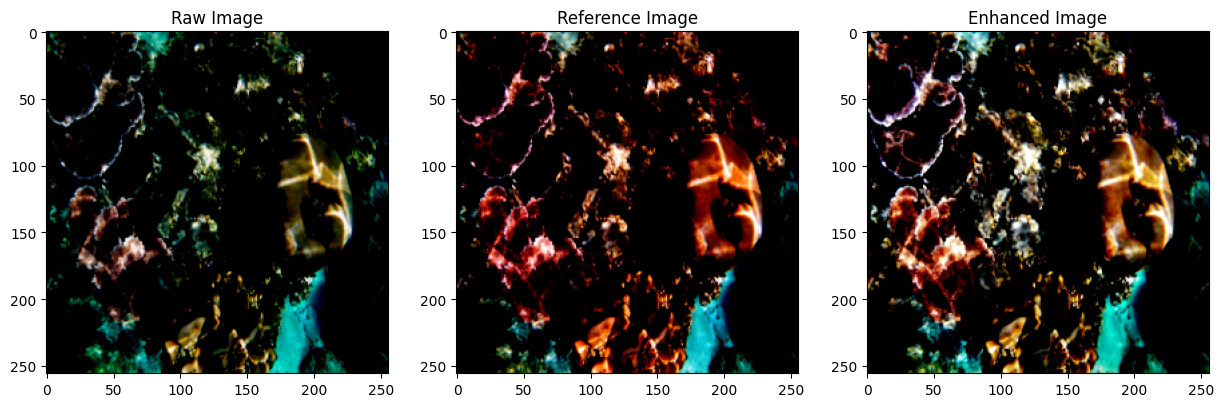

Average PSNR: 14.5933
Average SSIM: 0.5410
Average MSE: 0.0461


In [18]:
def evaluate_and_save_model(test_loader, generator, device, output_dir):
    psnr_values = []
    ssim_values = []
    mse_values = []

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():  # Disable gradient calculation for testing
        for idx, (raw_imgs, ref_imgs) in enumerate(test_loader):
            raw_imgs = raw_imgs.to(device)
            ref_imgs = ref_imgs.to(device)
            
            # Generate enhanced images
            enhanced_imgs = generator(raw_imgs)
            
            # Calculate PSNR and SSIM for each image
            for i in range(len(raw_imgs)):
                # Convert tensors to numpy for PSNR and SSIM calculations
                enhanced_img_np = enhanced_imgs[i].cpu().numpy().transpose(1, 2, 0)
                ref_img_np = ref_imgs[i].cpu().numpy().transpose(1, 2, 0)

                # Calculate metrics
                psnr_val = psnr(ref_img_np, enhanced_img_np, data_range=1)
                
                ssim_val = ssim(ref_img_np, enhanced_img_np, multichannel=True, win_size=3, data_range=1.0)
                
                mse_val = mean_squared_error(ref_img_np.flatten(), enhanced_img_np.flatten())

                psnr_values.append(psnr_val)
                ssim_values.append(ssim_val)
                mse_values.append(mse_val)

                # Save the enhanced image
                save_image(enhanced_imgs[i], os.path.join(output_dir, f"enhanced_{idx * len(raw_imgs) + i}.png"))

                # Plot some examples (optional)
                if i == 0 and idx == 0:  # Only plot the first batch as an example
                    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                    axs[0].imshow(raw_imgs[i].cpu().permute(1, 2, 0))
                    axs[0].set_title('Raw Image')
                    axs[1].imshow(ref_imgs[i].cpu().permute(1, 2, 0))
                    axs[1].set_title('Reference Image')
                    axs[2].imshow(enhanced_imgs[i].cpu().permute(1, 2, 0))
                    axs[2].set_title('Enhanced Image')
                    plt.show()

    # Calculate average metrics
    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    avg_mse = sum(mse_values) / len(mse_values)

    print(f'Average PSNR: {avg_psnr:.4f}')
    print(f'Average SSIM: {avg_ssim:.4f}')
    print(f'Average MSE: {avg_mse:.4f}')

# Specify the output directory
output_dir = "/kaggle/working/enhanced_images"

# Call the evaluation and save function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_and_save_model(test_loader, generator, device, output_dir)